# Lecture 5: Classification with Perceptron Model

In [2]:
%matplotlib inline
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import TensorDataset,DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
import PIL
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
import numpy as np
import pickle
import matplotlib.pyplot as plt

import time

### Loading saved features from disk

In [3]:
# Loading the saved features
with open("trainFeats.pckl", "rb") as f:
    trainFeats = pickle.load(f)
with open("trainLabel.pckl", "rb") as f:
    trainLabel = pickle.load(f)
    
with open("testFeats.pckl", "rb") as f:
    testFeats = pickle.load(f)
with open("testLabel.pckl", "rb") as f:
    testLabel = pickle.load(f)
    
print('Finished load saved feature matrices from the disk!')

Finished load saved feature matrices from the disk!


### Defining network architecture

In [4]:
# Defining the perceptron
class perceptron(nn.Module):
    def __init__(self,n_channels): #n_channels => length of feature vector
        super(perceptron, self).__init__()
        self.L = nn.Linear(n_channels,10) #Mapping from input to output
    def forward(self,x): #x => Input
        x = self.L(x) #Feed-forward  
        x = F.softmax(x) #Softmax non-linearity
        return x

### Dataset preparation

In [5]:
# Generating 1-hot label vectors
trainLabel2 = np.zeros((50000,10))
testLabel2 = np.zeros((10000,10))
for d1 in range(trainLabel.shape[0]):
    trainLabel2[d1,trainLabel[d1]] = 1
for d2 in range(testLabel.shape[0]):
    testLabel2[d2,testLabel[d2]] = 1

In [6]:
# Creating pytorch dataset from the feature matices
trainDataset = TensorDataset(torch.from_numpy(trainFeats), torch.from_numpy(trainLabel2))
testDataset = TensorDataset(torch.from_numpy(testFeats), torch.from_numpy(testLabel2))
# Creating dataloader
trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=True)
testLoader = DataLoader(testDataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=True)

In [7]:
# Checking availability of GPU
use_gpu = torch.cuda.is_available()

### Defining function for training the network

In [10]:
# Definining the training routine
def train_model(model,criterion,num_epochs,learning_rate):
        start = time.time()
        train_loss = [] #List for saving the loss per epoch    
        train_acc = [] #List for saving the accuracy per epoch  
        tempLabels = [] #List for saving shuffled labels as fed into the network
        for epoch in range(num_epochs):
            epochStartTime = time.time()
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))

            running_loss = 0.0           
            # Loading data in batches
            batch = 0
            for data in trainLoader:
                inputs,labels = data
                # Wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.float().cuda()), \
                        Variable(labels.float().cuda())
                else:
                    inputs, labels = Variable(inputs.float()), Variable(labels.float())    
                # Initializing model gradients to zero
                model.zero_grad() 
                # Data feed-forward through the network
                outputs = model(inputs)
                # Predicted class is the one with maximum probability
                _, preds = outputs.data.max(1)                 
                # Finding the MSE
                loss = criterion(outputs, labels)
                # Accumulating the loss for each batch
                #running_loss += tensloss.data[0]    
                running_loss +=loss.data
                
    
                # Backpropaging the error
                if batch == 0:
                    totalLoss = loss
                    totalPreds = preds                    
                    tempLabels = labels.data.cpu()
                    batch += 1                    
                else:
                    totalLoss += loss 
                    totalPreds = torch.cat((totalPreds,preds),0)                 
                    tempLabels = torch.cat((tempLabels,labels.data.cpu()),0)
                    batch += 1
                    
            totalLoss = totalLoss/batch
            totalLoss.backward()
            
            # Updating the model parameters
            for f in model.parameters():
                f.data.sub_(f.grad.data * learning_rate) 
                                    
            epoch_loss = running_loss/50000  #Total loss for one epoch
            train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
            
            # Accuracy per epoch
            tempLabels = tempLabels.numpy()
            _,totalLabels = np.where(tempLabels==1)                        
            epoch_acc = np.sum(np.equal(totalPreds.cpu().numpy(),np.array(totalLabels)))/50000.0      
            train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph
            
            epochTimeEnd = time.time()-epochStartTime
            print('Average epoch loss: {:.6f}'.format(epoch_loss))
            print('Average epoch accuracy: {:.6f}'.format(epoch_acc))
            print('-' * 25)
            # Plotting Loss vs Epochs
            fig1 = plt.figure(1)        
            plt.plot(range(epoch+1),train_loss,'r--',label='train')        
            if epoch==0:
                plt.legend(loc='upper left')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
            fig1.savefig('lossPlot.png')
             # Plotting Accuracy vs Epochs
            fig2 = plt.figure(2)        
            plt.plot(range(epoch+1),train_acc,'g--',label='train')        
            if epoch==0:
                plt.legend(loc='upper left')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
            fig2.savefig('accPlot.png')

        time_elapsed = time.time() - start
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        return model

### Training the perceptron

Epoch 0/99


C:\Users\asrivastava01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Average epoch loss: 0.001424
Average epoch accuracy: 0.082600
-------------------------
Epoch 1/99
Average epoch loss: 0.001424
Average epoch accuracy: 0.082660
-------------------------
Epoch 2/99
Average epoch loss: 0.001424
Average epoch accuracy: 0.082740
-------------------------
Epoch 3/99
Average epoch loss: 0.001424
Average epoch accuracy: 0.082740
-------------------------
Epoch 4/99
Average epoch loss: 0.001423
Average epoch accuracy: 0.082860
-------------------------
Epoch 5/99
Average epoch loss: 0.001423
Average epoch accuracy: 0.083000
-------------------------
Epoch 6/99
Average epoch loss: 0.001423
Average epoch accuracy: 0.083020
-------------------------
Epoch 7/99
Average epoch loss: 0.001423
Average epoch accuracy: 0.083060
-------------------------
Epoch 8/99
Average epoch loss: 0.001423
Average epoch accuracy: 0.083100
-------------------------
Epoch 9/99
Average epoch loss: 0.001423
Average epoch accuracy: 0.083120
-------------------------
Epoch 10/99
Average e

Average epoch loss: 0.001415
Average epoch accuracy: 0.087780
-------------------------
Epoch 83/99
Average epoch loss: 0.001415
Average epoch accuracy: 0.087820
-------------------------
Epoch 84/99
Average epoch loss: 0.001415
Average epoch accuracy: 0.087900
-------------------------
Epoch 85/99
Average epoch loss: 0.001415
Average epoch accuracy: 0.087960
-------------------------
Epoch 86/99
Average epoch loss: 0.001415
Average epoch accuracy: 0.088020
-------------------------
Epoch 87/99
Average epoch loss: 0.001415
Average epoch accuracy: 0.088100
-------------------------
Epoch 88/99
Average epoch loss: 0.001415
Average epoch accuracy: 0.088080
-------------------------
Epoch 89/99
Average epoch loss: 0.001415
Average epoch accuracy: 0.088220
-------------------------
Epoch 90/99
Average epoch loss: 0.001415
Average epoch accuracy: 0.088280
-------------------------
Epoch 91/99
Average epoch loss: 0.001415
Average epoch accuracy: 0.088300
-------------------------
Epoch 92/99


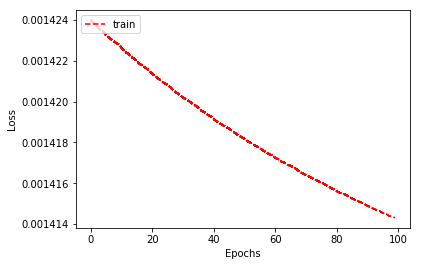

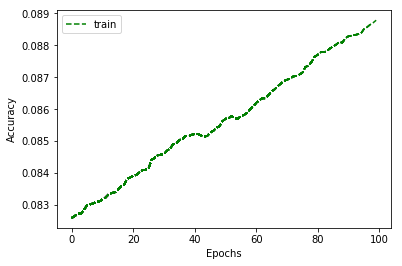

In [11]:
featLength = 2+5+2
model = perceptron(featLength)
if use_gpu:
    model = model.cuda() # Initilaizing the model
criterion = nn.MSELoss() 
model = train_model(model,criterion,num_epochs=100,learning_rate=1) # Training the model

### Performance evaluation of trained perceptron

In [14]:
# Finding testing accuracy
test_running_corr = 0
# Loading data in batches
batches = 0
tempLabels = []
for tsData in testLoader:
    inputs,labels = tsData
    # Wrap them in Variable
    if use_gpu:
        inputs, labels = Variable(inputs.float().cuda()), \
            Variable(labels.float().cuda())
    else:
        inputs, labels = Variable(inputs.float()), Variable(labels.float())        
    # Feedforward train data batch through model
    output = model(inputs) 
    # Predicted class is the one with maximum probability
    _,preds = output.data.max(1)    
    if batches==0:
        totalPreds = preds
        tempLabels = labels.data.cpu()
        batches = 1
    else:
        totalPreds = torch.cat((totalPreds,preds),0)
        tempLabels = torch.cat((tempLabels,labels.data.cpu()),0) 
# Converting 1-hot vector labels to interget labels
tempLabels = tempLabels.numpy()
compLabels = np.zeros(10000)
for i in range(10000):    
    compLabels[i] = np.where(tempLabels[i,:]==1)[0][0]
# Finding total number of correct predictions
ts_corr = np.sum(np.equal(totalPreds.cpu().numpy(),compLabels))
# Calculating accuracy
ts_acc = ts_corr/10000.0
print('Accuracy on test set = '+str(ts_acc))

C:\Users\asrivastava01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Accuracy on test set = 0.0037


# Very bad accuracy lets improve further !!!